In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

np.set_printoptions(linewidth=250)
%matplotlib inline

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss

In [4]:
font = {'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# Calibrating a Random Forest Classifier
Using a minimum amount of code, this notebook demonstrates a way to calibrate the scikit-learn implementation of Random Forest.

## Create some classification test data

In [50]:
X, y = make_classification(n_samples=20000, n_features=3, n_informative=3, n_redundant=0, random_state=0, shuffle=False)

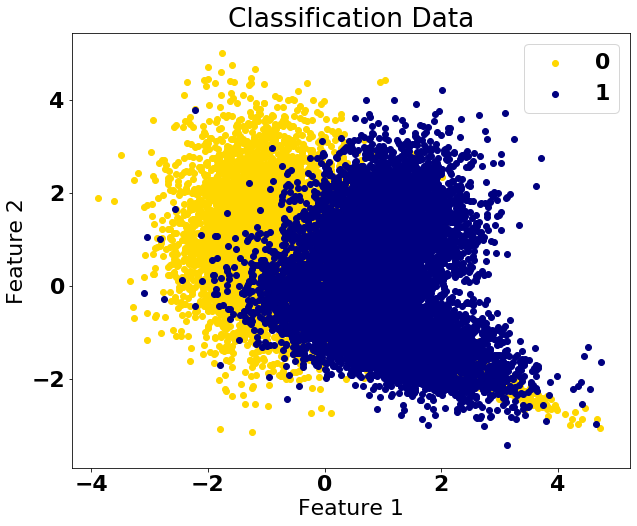

In [65]:
cdict = {0: 'gold', 1: 'navy'}
fig, ax = plt.subplots(figsize=(10,8))
for g in np.unique(y):
    ix = np.where(y == g)
    ax.scatter(X[ix, 1], X[ix, 2], c = cdict[g], label = g)
ax.legend()
plt.xlabel('Feature 1');
plt.ylabel('Feature 2');
plt.title('Classification Data')
plt.show()

## Train a random forest classifier with and without calibration

In [51]:
## Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [53]:
# No calibration
clf = RandomForestClassifier(max_depth=3, random_state=0, min_samples_leaf=3).fit(X_train, y_train)
predictions_rf = clf.predict_proba(X_test)

# Isotonic calibration
clf = RandomForestClassifier(max_depth=3, random_state=0, min_samples_leaf=3)
clf_isotonic = CalibratedClassifierCV(clf, method='isotonic')
clf_isotonic.fit(X_train, y_train)
predictions_isotonic = clf_isotonic.predict_proba(X_test)

## Compare the probability predictions

In [54]:
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [55]:
## Here we are binning the predictions from the random forest prediction 
## and then looking at the percentage of each bin that is assigned to the positive class
predictions_df = pd.DataFrame(predictions_rf)
predictions_df['actual'] = y_test
predictions_df['bin'] = pd.cut(predictions_df[1], bins)
predictions_df['bin_mid'] = predictions_df['bin'].apply(lambda x: x.mid).astype(float)
bin_df = predictions_df.groupby('bin_mid').actual.mean().reset_index()

In [56]:
## Here we are binning the predictions from the isotonic calibration
## and then looking at the percentage of each bin that is assigned to the positive class
predictions_isotonic_df = pd.DataFrame(predictions_isotonic)
predictions_isotonic_df['actual'] = y_test
predictions_isotonic_df['bin'] = pd.cut(predictions_isotonic_df[1], bins)
predictions_isotonic_df['bin_mid'] = predictions_isotonic_df['bin'].apply(lambda x: x.mid).astype(float)
bin_isotonic_df = predictions_isotonic_df.groupby('bin_mid').actual.mean().reset_index()

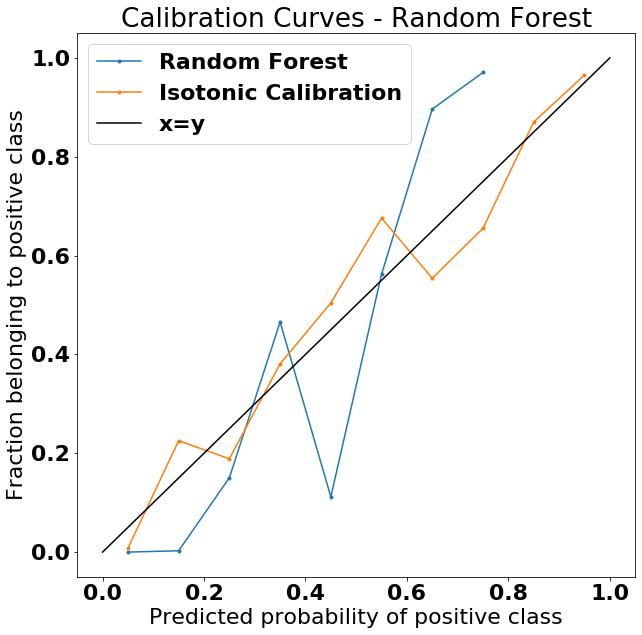

In [63]:
## Finally, plot the binned predictions
plt.figure(figsize=(10,10))
plt.plot(bin_df.bin_mid, bin_df.actual, '.-');
plt.plot(bin_isotonic_df.bin_mid, bin_isotonic_df.actual, '.-');
plt.plot([0,1], [0,1], 'k')
plt.legend(['Random Forest', 'Isotonic Calibration', 'x=y']);
plt.xlabel('Predicted probability of positive class');
plt.ylabel('Fraction belonging to positive class');
plt.title('Calibration Curves - Random Forest');

## Compute the Brier score
The Brier score is really just the mean-squared error of the forecast.

In [64]:
print("Brier scores: (the smaller the better)")

clf_score = brier_score_loss(y_test, predictions_rf[:,1])
print("No calibration: %1.3f" % clf_score)

clf_isotonic_score = brier_score_loss(y_test, predictions_isotonic[:,1])
print("With isotonic calibration: %1.3f" % clf_isotonic_score)

Brier scores: (the smaller the better)
No calibration: 0.152
With isotonic calibration: 0.094
